# Φόρτωση Δεδομένων

### Βημα 1

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torchtext

from PIL import Image
from pathlib import Path

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# My imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from utils import smooth
import numpy as np

In [2]:
# Φορτώστε τα δεδομένα από τα CSV αρχεία χρησιμοποιώντας το pandas
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

data = pd.concat([train_data, test_data])

classes = data.Classes.unique()

class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

In [3]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Assuming the first column contains file paths
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]  # Assuming the second column contains labels
        
        # Convert label to integer using class_to_idx dictionary
        label = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)

        return image, label

Στον παραπάνω κώδικα, η κλάση FoodDataset δέχεται ένα DataFrame ως είσοδο κατά την αρχικοποίηση και μπορεί να εφαρμόσει μετασχηματισμούς στις εικόνες αν το επιθυμείτε. Η μέθοδος __getitem__ επιστρέφει την εικόνα και την ετικέτα της για ένα συγκεκριμένο δείγμα.

In [4]:
# Διαίρεση σε σύνολα εκπαίδευσης και επικύρωσης
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Ορίστε τους μετασχηματισμούς που επιθυμείτε να εφαρμόσετε στις εικόνες
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Αλλάξτε το μέγεθος των εικόνων σε 224x224
    transforms.ToTensor(),  # Μετατρέψτε τις εικόνες σε tensors
    # Προσθέστε άλλους μετασχηματισμούς που χρειάζεστε
])

# Δημιουργία των FoodDataset instances
train_dataset = FoodDataset(train_set, transform=transform)
val_dataset = FoodDataset(val_set, transform=transform)

# Δημιουργία των PyTorch Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Αυτός ο κώδικας θα δημιουργήσει τα train_loader και val_loader που θα χρησιμοποιηθούν για την εκπαίδευση και την επικύρωση του μοντέλου σας αντίστοιχα. Είναι σημαντικό να εισάγετε τις απαραίτητες βιβλιοθήκες όπως το torch, torchvision, PIL, και pandas, και να προσαρμόσετε τα μονοπάτια για τα αρχεία CSV και τα μετασχηματισμούς στις ανάγκες του προγράμματός σας.

### Βημα 2

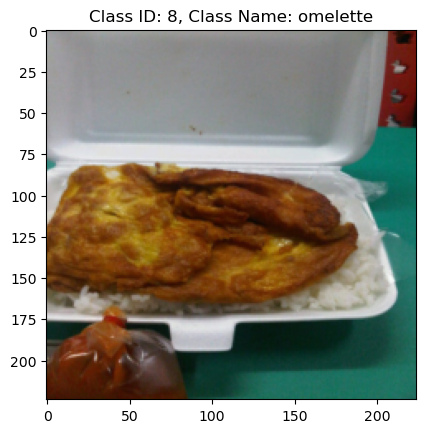

In [5]:
# Λειτουργία για να εμφανίζουμε τις εικόνες μαζί με το όνομα της κλάσης
def imshow_with_class(img, class_id, classes):
    class_name = list(classes.keys())[list(classes.values()).index(class_id)]
    plt.imshow(img.permute(1, 2, 0))  # Μετατροπή του tensor σε μορφή εικόνας (H, W, C)
    plt.title(f'Class ID: {class_id}, Class Name: {class_name}')
    plt.show()

# Λήψη ενός batch από τα δεδομένα εκπαίδευσης
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Εμφάνιση του πρώτου δείγματος από το batch
class_id = labels[0].item()
imshow_with_class(images[0], class_id, class_to_idx)

Αυτός ο κώδικας θα προβάλει την πρώτη εικόνα από το πρώτο batch, μαζί με την αντίστοιχη ετικέτα. Μπορείτε να το εκτελέσετε για να δείτε αν τα δεδομένα φορτώνονται σωστά και αν οι ετικέτες είναι σωστές.

### Βημα 3

Η συνάρτηση train_model θα πρέπει να εκπαιδεύει το μοντέλο για έναν συγκεκριμένο αριθμό εποχών, χρησιμοποιώντας έναν επιλεγμένο αλγόριθμο βελτιστοποίησης και ένα κριτήριο απώλειας. Κατά τη διάρκεια κάθε εποχής, θα πρέπει να υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης για να ελεγχθεί η απόδοση του μοντέλου. Στο τέλος κάθε εποχής, θα πρέπει να αποθηκεύονται οι μετρικές αυτές για μελλοντική αναφορά.

Αυτή η συνάρτηση θα εκπαιδεύει το μοντέλο για τον αριθμό των εποχών που καθορίζετε. Κατά τη διάρκεια κάθε εποχής, υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης και αποθηκεύονται για μελλοντική αναφορά. Επιστρέφει τα ιστορικά των μετρικών για εκπαίδευση και επικύρωση.

Ας προχωρήσουμε τώρα στη συνάρτηση evaluate_model.

Η συνάρτηση evaluate_model θα χρησιμοποιηθεί για τον έλεγχο της απόδοσης του μοντέλου σε ένα σύνολο δεδομένων, είτε στο σύνολο επικύρωσης είτε στο σύνολο δοκιμής. Αυτή η συνάρτηση θα υπολογίζει την απώλεια και την ακρίβεια του μοντέλου.

In [6]:
# Ορίζουμε τη συσκευή εκτέλεσης (device) που θα χρησιμοποιήσουμε
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ορίζουμε τη συνάρτηση εκπαίδευσης
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    # Αρχικοποίηση μετρικών
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    # Μετακινούμε το μοντέλο στη συσκευή εκτέλεσης
    model = model.to(device)
    
    # Ξεκινάμε την εκπαίδευση
    for epoch in range(num_epochs):
        # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
        model.train()
        
        # Αρχικοποίηση των μετρικών
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Εκπαίδευση του μοντέλου σε κάθε batch
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            # Μηδενίζουμε τις καταχωρήσεις των gradients
            optimizer.zero_grad()
            
            # Προϋπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Αντίστροφη διάδοση του σφάλματος και ενημέρωση των βαρών
            loss.backward()
            optimizer.step()
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Εκτύπωση της απώλειας και της ακρίβειας στο σύνολο εκπαίδευσης
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        
        # Αξιολόγηση του μοντέλου στο σύνολο επικύρωσης
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Έλεγχος για πρόωρο τερματισμό αν δεν υπάρχει βελτίωση στο σύνολο επικύρωσης
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break
    
    print("Training completed.")

# Ορίζουμε τη συνάρτηση αξιολόγησης
def evaluate_model(model, data_loader, criterion):
    # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    model.eval()
    
    # Αρχικοποίηση των μετρικών
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Αξιολόγηση του μοντέλου στα δεδομένα
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Υπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Υπολογισμός της απώλειας και της ακρίβειας
    loss = running_loss / len(data_loader)
    accuracy = correct / total
    
    return loss, accuracy

Αυτή η συνάρτηση αξιολογεί το μοντέλο στο δεδομένο data_loader, υπολογίζοντας την απώλεια και την ακρίβεια. Επιστρέφει επίσης την απώλεια και την ακρίβεια για μελλοντική αναφορά.

Αυτές οι συναρτήσεις μπορούν να χρησιμοποιηθούν για την εκπαίδευση και την αξιολόγηση ενός μοντέλου στο PyTorch.

### **1. Ποιος ο λόγος που έχουμε κρατήσει ένα κομμάτι του συνόλου εκπαίδευσης ως σύνολο επικύρωσης; ∆ε θα ήταν πιο λογικό να έχουμε περισσότερα δεδομένα για να εκπαιδεύσουμε τα μοντέλα μας; Εξηγήστε.**


Η κράτηση ενός κομματιού του συνόλου εκπαίδευσης ως σύνολο επικύρωσης έχει ως στόχο την αξιολόγηση της γενικευτικής ικανότητας του μοντέλου. Το σύνολο επικύρωσης χρησιμεύει για την επίβλεψη της απόδοσης του μοντέλου κατά τη διάρκεια της εκπαίδευσης και της προσαρμογής των υπερπαραμέτρων του μοντέλου (όπως ο ρυθμός μάθησης) ώστε να αποφευχθεί το overfitting. Η χρήση ενός ξεχωριστού συνόλου επικύρωσης βοηθά στην αποφυγή του overfitting και στη βελτίωση της γενίκευσης του μοντέλου. Αν εκπαιδεύαμε το μοντέλο με όλα τα δεδομένα, θα υπήρχε ο κίνδυνος να είναι πολύ καλό στο σύνολο εκπαίδευσης αλλά να μην γενικεύει καλά σε νέα δεδομένα.

### **2. Τί πρόβλημα καλούμαστε να λύσουμε στο συγκεκριμένο dataset; Ποια είναι η κατάλληλη συνάρτηση απώλειας για να εκπαιδεύσουμε ένα μοντέλο για ένα τέτοιου είδους προβλήματος;**

Το πρόβλημα που καλούμαστε να λύσουμε στο συγκεκριμένο dataset είναι η αναγνώριση της κατηγορίας των τροφίμων από εικόνες. Αυτό είναι ένα πρόβλημα ταξινόμησης πολλαπλών κατηγοριών, όπου κάθε εικόνα μπορεί να ανήκει σε μία από πολλές διαφορετικές κατηγορίες τροφίμων. Για την εκπαίδευση ενός μοντέλου για ένα τέτοιο πρόβλημα, μια κατάλληλη συνάρτηση απώλειας είναι η κατηγορική απώλεια (categorical cross-entropy), η οποία είναι κατάλληλη για την αναγνώριση πολλαπλών κατηγοριών.

# Εκπαίδευση Συνελικτικών ∆ικτύων

Αυτό το δίκτυο έχει τα επίπεδα που περιγράψατε, συμπεριλαμβανομένων τριών συνελικτικών επιπέδων, τριών επιπέδων συγκέντρωσης και ενός πλήρως συνδεδεμένου επιπέδου για την ταξινόμηση σε num_classes κλάσεις.

Αρχικοποιήστε το παραπάνω μοντέλο ΣΝ∆ και εκπαιδεύστε υλοποιώντας τα παρακάτω

• Αλγόριθμο βελτιστοποίησης Adam με ρυθμό εκμάθησης 10^4

• Εκτύπωση της απώλειας (loss), ορθότητας (accuracy) των υποσυνόλων εκπαίδευσης και επικύρωσης

• 30 εποχές μέγιστη διάρκεια εκπαίδευσης

• Πρόωρο τερματισμό της εκπαίδευσης (Early Stopping) αν δεν παρουσιαστεί μείωση της απώλειας στο
σύνολο επικύρωσης για 5 συνεχείς εποχές

In [7]:
class SmallNet(nn.Module):
    def __init__(self, num_classes=11):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(128 * 28 * 28, num_classes)  # 28x28 after 3 max pooling layers
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        return x

smallnet_model = SmallNet()

### Εκπαίδευση Συνελικτικών ∆ικτύων

In [9]:
# Create an instance of the BigNet model
smallnet_model = SmallNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(smallnet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
train_model(smallnet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.66it/s]


Train Loss: 2.2833, Train Accuracy: 0.1812
Validation Loss: 2.1669, Validation Accuracy: 0.2389


Epoch 2/30: 100%|██████████| 124/124 [00:17<00:00,  6.96it/s]


Train Loss: 2.0771, Train Accuracy: 0.2861
Validation Loss: 2.0553, Validation Accuracy: 0.2944


Epoch 3/30: 100%|██████████| 124/124 [00:17<00:00,  7.02it/s]


Train Loss: 1.9179, Train Accuracy: 0.3620
Validation Loss: 1.9754, Validation Accuracy: 0.3187


Epoch 4/30: 100%|██████████| 124/124 [00:17<00:00,  6.97it/s]


Train Loss: 1.8078, Train Accuracy: 0.4033
Validation Loss: 1.9447, Validation Accuracy: 0.3399


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.74it/s]


Train Loss: 1.6856, Train Accuracy: 0.4501
Validation Loss: 1.9247, Validation Accuracy: 0.3540


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.84it/s]


Train Loss: 1.5572, Train Accuracy: 0.4979
Validation Loss: 1.9865, Validation Accuracy: 0.3465


Epoch 7/30: 100%|██████████| 124/124 [00:17<00:00,  6.99it/s]


Train Loss: 1.3846, Train Accuracy: 0.5615
Validation Loss: 1.9393, Validation Accuracy: 0.3586


Epoch 8/30: 100%|██████████| 124/124 [00:17<00:00,  6.96it/s]


Train Loss: 1.2631, Train Accuracy: 0.6001
Validation Loss: 1.9638, Validation Accuracy: 0.3616


Epoch 9/30: 100%|██████████| 124/124 [00:17<00:00,  6.96it/s]


Train Loss: 1.1003, Train Accuracy: 0.6553
Validation Loss: 2.0503, Validation Accuracy: 0.3652


Epoch 10/30: 100%|██████████| 124/124 [00:17<00:00,  7.06it/s]


Train Loss: 0.9541, Train Accuracy: 0.7096
Validation Loss: 2.1667, Validation Accuracy: 0.3475
No improvement for 5 epochs. Early stopping...
Training completed.


### Αξιολόγηση

 ## Συνελικτικό δίκτυο μεγάλου βάθους

Αυτό το μοντέλο αντιστοιχεί στην περιγραφή που μου δώσατε, με τρία συνελικτικά επίπεδα ακολουθούμενα από επίπεδα συγκέντρωσης (Max pooling) και ένα πλήρως συνδεδεμένο επίπεδο στο τέλος.


Ο μεγάλος αριθμός επιπέδων και νευρώνων στο BigNet μοντέλο μπορεί να οδηγήσει σε προβλήματα υπερ-προσαρμογής (overfitting), ιδίως αν το μοντέλο δεν έχει κατάλληλη τεχνική ομαλοποίησης και ελέγχου χωρητικότητας.

Μια τεχνική ομαλοποίησης που μπορεί να χρησιμοποιηθεί είναι η απόσυρση (dropout). Η απόσυρση μπορεί να εφαρμοστεί μεταξύ των πλήρως συνδεδεμένων επιπέδων για να αποτρέψει την υπερ-προσαρμογή. Επιπλέον, μπορεί να χρησιμοποιηθεί η κανονικοποίηση βάρους (weight regularization), όπως η L2 κανονικοποίηση, για να ελέγξει το μέγεθος των βαρών του μοντέλου και να αποτρέψει την υπερ-προσαρμογή.

Ωστόσο, το παραπάνω BigNet μοντέλο δεν περιλαμβάνει αυτές τις τεχνικές. Για να προσθέσετε απόσυρση ή κανονικοποίηση βάρους, μπορείτε να προσθέσετε τα αντίστοιχα επίπεδα στο μοντέλο και να τα ενεργοποιήσετε κατά την εκπαίδευση.

In [8]:
class BigNet(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 11)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [10]:
# Create an instance of the BigNet model
bignet_model = BigNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
train_model(bignet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:19<00:00,  6.50it/s]


Train Loss: 2.3120, Train Accuracy: 0.1620
Validation Loss: 2.2214, Validation Accuracy: 0.2091


Epoch 2/30: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


Train Loss: 2.1343, Train Accuracy: 0.2514
Validation Loss: 2.1060, Validation Accuracy: 0.2571


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.63it/s]


Train Loss: 2.0074, Train Accuracy: 0.3066
Validation Loss: 2.0272, Validation Accuracy: 0.3101


Epoch 4/30: 100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


Train Loss: 1.8967, Train Accuracy: 0.3540
Validation Loss: 1.9816, Validation Accuracy: 0.3217


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.62it/s]


Train Loss: 1.7734, Train Accuracy: 0.4011
Validation Loss: 1.9383, Validation Accuracy: 0.3399


Epoch 6/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 1.6695, Train Accuracy: 0.4370
Validation Loss: 1.9335, Validation Accuracy: 0.3434


Epoch 7/30: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


Train Loss: 1.5611, Train Accuracy: 0.4826
Validation Loss: 1.9093, Validation Accuracy: 0.3631


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 1.4311, Train Accuracy: 0.5294
Validation Loss: 1.9008, Validation Accuracy: 0.3753


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.45it/s]


Train Loss: 1.2856, Train Accuracy: 0.5845
Validation Loss: 1.9633, Validation Accuracy: 0.3657


Epoch 10/30: 100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


Train Loss: 1.1347, Train Accuracy: 0.6346
Validation Loss: 2.0090, Validation Accuracy: 0.3631


Epoch 11/30: 100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


Train Loss: 0.9727, Train Accuracy: 0.6920
Validation Loss: 2.1100, Validation Accuracy: 0.3631


Epoch 12/30: 100%|██████████| 124/124 [00:19<00:00,  6.37it/s]


Train Loss: 0.8162, Train Accuracy: 0.7429
Validation Loss: 2.1630, Validation Accuracy: 0.3616


Epoch 13/30: 100%|██████████| 124/124 [00:19<00:00,  6.44it/s]


Train Loss: 0.6367, Train Accuracy: 0.8047
Validation Loss: 2.2146, Validation Accuracy: 0.3798
No improvement for 5 epochs. Early stopping...
Training completed.
